In [5]:
!pip install -q transformers nltk tensorflow tensorflow-hub tensorflow_text


In [6]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [7]:
train_prompt_file = "/content/train_prompts.csv"
df_train_prompt = pd.read_csv(train_prompt_file)

train_essay_file = "/content/train_essays.csv"
df_train_essay = pd.read_csv(train_essay_file)

test_essay_file = "/content/test_essays.csv"
df_test_essay = pd.read_csv(test_essay_file)

sub_file = "/content/sample_submission.csv"
df_sub = pd.read_csv(sub_file)

In [8]:
df_train_essay.head()


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [9]:
df_train_essay.shape

(1378, 4)

In [10]:
df_train_essay['generated'].unique()

array([0, 1])

In [11]:
df_train_essay['text'][0]

'Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.\n\nIn like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go. Article

In [12]:
df_train_prompt.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


so basically the dataset has AI generated and human written essays.  the AI generated essays were generated by prompting an LLM which is described in the df_train_prompt. The essays themselves are in df_train_essays.

<function matplotlib.pyplot.show(close=None, block=None)>

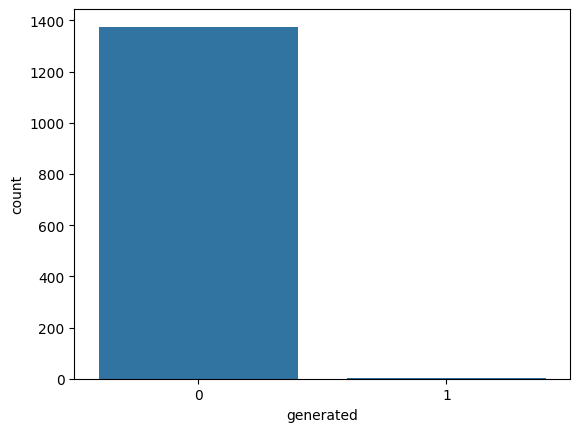

In [13]:
sns.countplot(x=df_train_essay['generated'])
plt.show
# a lot of generated but less human written. High class imbalance.

In [14]:
df_train_essay["prompt_id"].value_counts()
#nearly equal essays from the 2 different topics

prompt_id
0    708
1    670
Name: count, dtype: int64

In [15]:
train_essay_ex_file = "/content/train_v2_drcat_02.csv"
df_train_essay_ex = pd.read_csv(train_essay_ex_file)

In [16]:
df_train_essay_ex.head()
#extra essays to train the model on

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [17]:
df_train_essay_ex['label'].unique()

array([0, 1])

In [18]:
df_train_essay_ex.rename(columns = {"label":"generated"}, inplace=True)
df_train_essay_ex['generated'].value_counts()


generated
0    27370
1    17497
Name: count, dtype: int64

In [19]:
df_train_essay_ex.head()

,text,generated,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [20]:
df_train = pd.concat([df_train_essay_ex[["text", "generated"]],
                                   df_train_essay[["text", "generated"]]])
#consolidating both training datasets

In [21]:
df_train.head()

,text,generated
0,Phones\n\nModern humans today are always on th...,0
1,This essay will explain if drivers should or s...,0
2,Driving while the use of cellular devices\n\nT...,0
3,Phones & Driving\n\nDrivers should not be able...,0
4,Cell Phone Operation While Driving\n\nThe abil...,0


In [22]:
df_train.shape

(46245, 2)

In [23]:
df_train['generated'].value_counts()


generated
0    28745
1    17500
Name: count, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

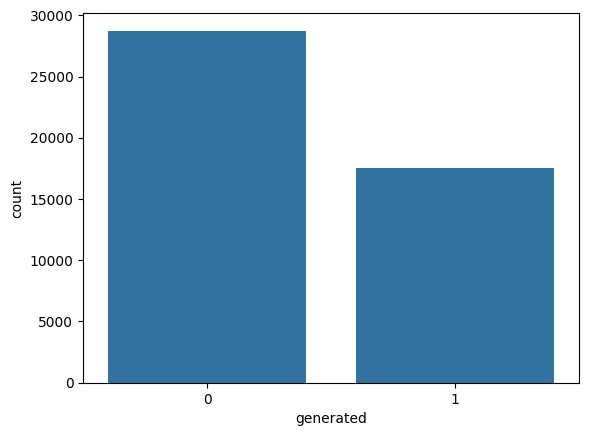

In [24]:
sns.countplot(x=df_train['generated'])
plt.show
#class imbalance

In [25]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

nltk.download('stopwords')
nltk.download('punkt')

def remove_stopwords(input_text, language='english'):
  words = word_tokenize(input_text['text'])

  print(f"Index {input_text['index_col']}") if input_text['index_col'] % 10000 == 0 else None

    # Remove stopwords
  filtered_words = [word for word in words if word.lower() not in stopwords.words(language)]

    # Join the filtered words to form the cleaned text
  cleaned_text = ' '.join(filtered_words)

  return cleaned_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [26]:
from sklearn.model_selection import train_test_split

x, y = df_train['text'], df_train['generated']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=2529)

In [29]:
!pip install keras_nlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.1/572.1 kB 7.4 MB/s eta 0:00:00


In [30]:
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
import keras_nlp

In [31]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_base_en_uncased",trainable=True)
encoder_inputs = preprocessor(text_input)
encoder = keras_nlp.models.BertBackbone.from_preset("bert_base_en_uncased")
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]
sequence_output = outputs["sequence_output"]

100%|██████████| 141/141 [00:00<00:00, 216kB/s]


100%|██████████| 547/547 [00:00<00:00, 825kB/s]


100%|██████████| 226k/226k [00:00<00:00, 41.7MB/s]


100%|██████████| 510/510 [00:00<00:00, 672kB/s]


100%|██████████| 418M/418M [00:04<00:00, 89.2MB/s]


In [33]:
outputs

{'sequence_output': <KerasTensor shape=(None, 512, 768), dtype=float32, sparse=False, name=keras_tensor_41>,
 'pooled_output': <KerasTensor shape=(None, 768), dtype=float32, sparse=False, name=keras_tensor_43>}

In [34]:

dense_1 = tf.keras.layers.Dense(128 , activation='relu')(pooled_output)
dropout = tf.keras.layers.Dropout(0.7 , name="dropout1")(pooled_output)
dense_2 = tf.keras.layers.Dense(64 , activation='relu')(dropout)
dropout = tf.keras.layers.Dropout(0.5 , name="dropout2")(dense_2)

dense_out = tf.keras.layers.Dense(1 , activation='sigmoid', name='output')(dropout)


model = tf.keras.Model(inputs=text_input, outputs=dense_out)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_preprocessor         │ [(None, 512), (None,   │              0 │ input_layer[0][0]      │
│ (BertPreprocessor)        │ 512), (None, 512)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_backbone             │ [(None, 768), (None,   │    109,482,240 │ bert_preprocessor[0][… │
│ (BertBackbone)            │ 512, 768)]             │                │ bert_preprocessor[0][… │
│                           │                        │                │ bert_preprocessor[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout1 (Dropout)        │ (None, 768)            │              0 │ bert_backbone[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │         49,216 │ dropout1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout2 (Dropout)        │ (None, 64)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 1)              │             65 │ dropout2[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 109,531,521 (417.83 MB)

 Trainable params: 109,531,521 (417.83 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss='binary_crossentropy',
              metrics=["acc"])

checkpoint_filepath = 'checkpoint.keras'
metric = 'val_accuracy'
callback_list = [tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                    monitor=metric,
                                                    verbose=2,
                                                    save_best_only=True,
                                                    mode='max'),
                 tf.keras.callbacks.EarlyStopping(monitor=metric,
                                                  patience=0,
                                                  restore_best_weights=True)
                ]
history = model.fit(x_train, y_train , batch_size=8, callbacks=[callback_list],
                    epochs=5 , validation_data=(x_test, y_test))
# model.load_weights(checkpoint_filepath)
model.save("model-bert")